In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '0'

# name of the synthetic directory
sim_name = 'canon_g1_fla'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 5.23457
gp_id = 1.16
blg_id = -1
mod_id = 123
svi_id = 25 # (24,25) =  (no outer roi, outer roi)
sim_seed = 1000
svi_seed = 0

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
ebin = 10
temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [4]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

/
    ebin10_smp_svi_0.1_15000_mvn_8_1000_0.p
    __init__.py
    summary.txt
    settings_7p1234567_5p23457_1p16_-1_123_24_1000_0.py
    ebin10_svi_res_0.1_15000_mvn_8_1000_0.p


In [5]:
# load model using stored parameters

from models.poissonian_ed_amarel_customroi import EbinPoissonModel # to set GPU at the beginning

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )
# configure model, run SVI, and generate samp 
ebinmodel.config_model(ebin=ebin)

In [6]:
def truncate_samples(samples, n_samples):
    for key in samples.keys():
        samples[key] = samples[key][:n_samples]
    return samples

In [7]:
# sim_seed = 1000
# str_sim_seed = str(sim_seed)

# fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
# fit_dir = data_dir + 'fits/' + fit_filename + '/'

# # load saved data from GP -> Data fit
# gp_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
#             str_lr + '_' + str_n_steps + '_' + 
#                str_guide + '_' + str_num_particles + '_' + 
#                str_sim_seed + '_' + str_svi_seed + '.p')

# if is_gp:
#    samples, svi_results, gp_samples = pickle.load(open(fit_dir + gp_file_name, 'rb'))
# else:
#    samples, svi_results = pickle.load(open(fit_dir + gp_file_name, 'rb'))

#    samples = truncate_samples(samples,1000)
#    gp_samples = gp_samples

In [8]:
sim_seeds = np.arange(1000, 1010)

aug_samples = []
aug_gp_samples = []

for sim_seed in sim_seeds:
   str_sim_seed = str(sim_seed)
   
   fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
   fit_dir = data_dir + 'fits/' + fit_filename + '/'

   # load saved data from GP -> Data fit
   gp_file_name = ('ebin' + str_ebin + '_smp_svi_' + 
               str_lr + '_' + str_n_steps + '_' + 
                  str_guide + '_' + str_num_particles + '_' + 
                  str_sim_seed + '_' + str_svi_seed + '.p')

   if is_gp:
      samples, svi_results, gp_samples = pickle.load(open(fit_dir + gp_file_name, 'rb'))
   else:
      samples, svi_results = pickle.load(open(fit_dir + gp_file_name, 'rb'))

   samples = truncate_samples(samples,1000)
   gp_samples = gp_samples[:1000,:]

   if len(aug_samples) == 0:
      aug_samples = samples
   else:
      for key in samples.keys():
         aug_samples[key] = np.concatenate((aug_samples[key], samples[key]))

   if len(aug_gp_samples) == 0:
      aug_gp_samples = gp_samples
   else:
      aug_gp_samples = np.concatenate((aug_gp_samples, gp_samples), axis = 0)

samples = aug_samples
gp_samples = aug_gp_samples

In [9]:
temp_sample_dict = ef.generate_temp_sample_maps_theta(samples, ebinmodel, gp_samples = gp_samples, custom_num=None, nfw_gamma=nfw_gamma)

iso
psc
bub
pib


100%|██████████| 10000/10000 [00:00<00:00, 91443.92it/s]


ics


100%|██████████| 10000/10000 [00:00<00:00, 90173.13it/s]


In [10]:
keys = list(samples.keys())
keys.remove('log_rate_u')

temp_samples_tot_list = []
for k in keys:
    if 'theta' in k:
        for i in range(len(ebinmodel.dif_names)):
            temp_samples_tot_list.append(samples[k][:,i])
    else:
        temp_samples_tot_list.append(samples[k])
temp_samples_tot_list = np.array(temp_samples_tot_list)

# generate samples and plot histograms of log counts
nside = ebinmodel.nside
mask = ebinmodel.mask_roi_arr[ebin]

ebin = 10
temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file

true_params = {}
true_params['S_bub'] = temp_dict['S_bub']
true_params['S_ics'] = temp_dict['S_ics']
true_params['S_pib'] = temp_dict['S_pib']
true_params['S_psc'] = temp_dict['S_psc']
true_params['S_blg'] = temp_dict['S_blg']
true_params['S_iso'] = temp_dict['S_iso']
true_params['S_nfw'] = temp_dict['S_nfw']
true_params['gamma'] = 1.

['S_bub', 'S_ics', 'S_iso', 'S_pib', 'S_psc', 'theta_ics', 'theta_pib']
theta_ics
['$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{pib}$', '$S_{psc}$', '$\\theta_{ics}^{o}$']
theta_ics
['$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{pib}$', '$S_{psc}$', '$\\theta_{ics}^{o}$', '$\\theta_{ics}^{a}$']
theta_pib
['$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{pib}$', '$S_{psc}$', '$\\theta_{ics}^{o}$', '$\\theta_{ics}^{a}$', '$\\theta_{pib}^{o}$']
theta_pib
['$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{pib}$', '$S_{psc}$', '$\\theta_{ics}^{o}$', '$\\theta_{ics}^{a}$', '$\\theta_{pib}^{o}$', '$\\theta_{pib}^{a}$']
['$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{pib}$', '$S_{psc}$', '$\\theta_{ics}^{o}$', '$\\theta_{ics}^{a}$', '$\\theta_{pib}^{o}$', '$\\theta_{pib}^{a}$']


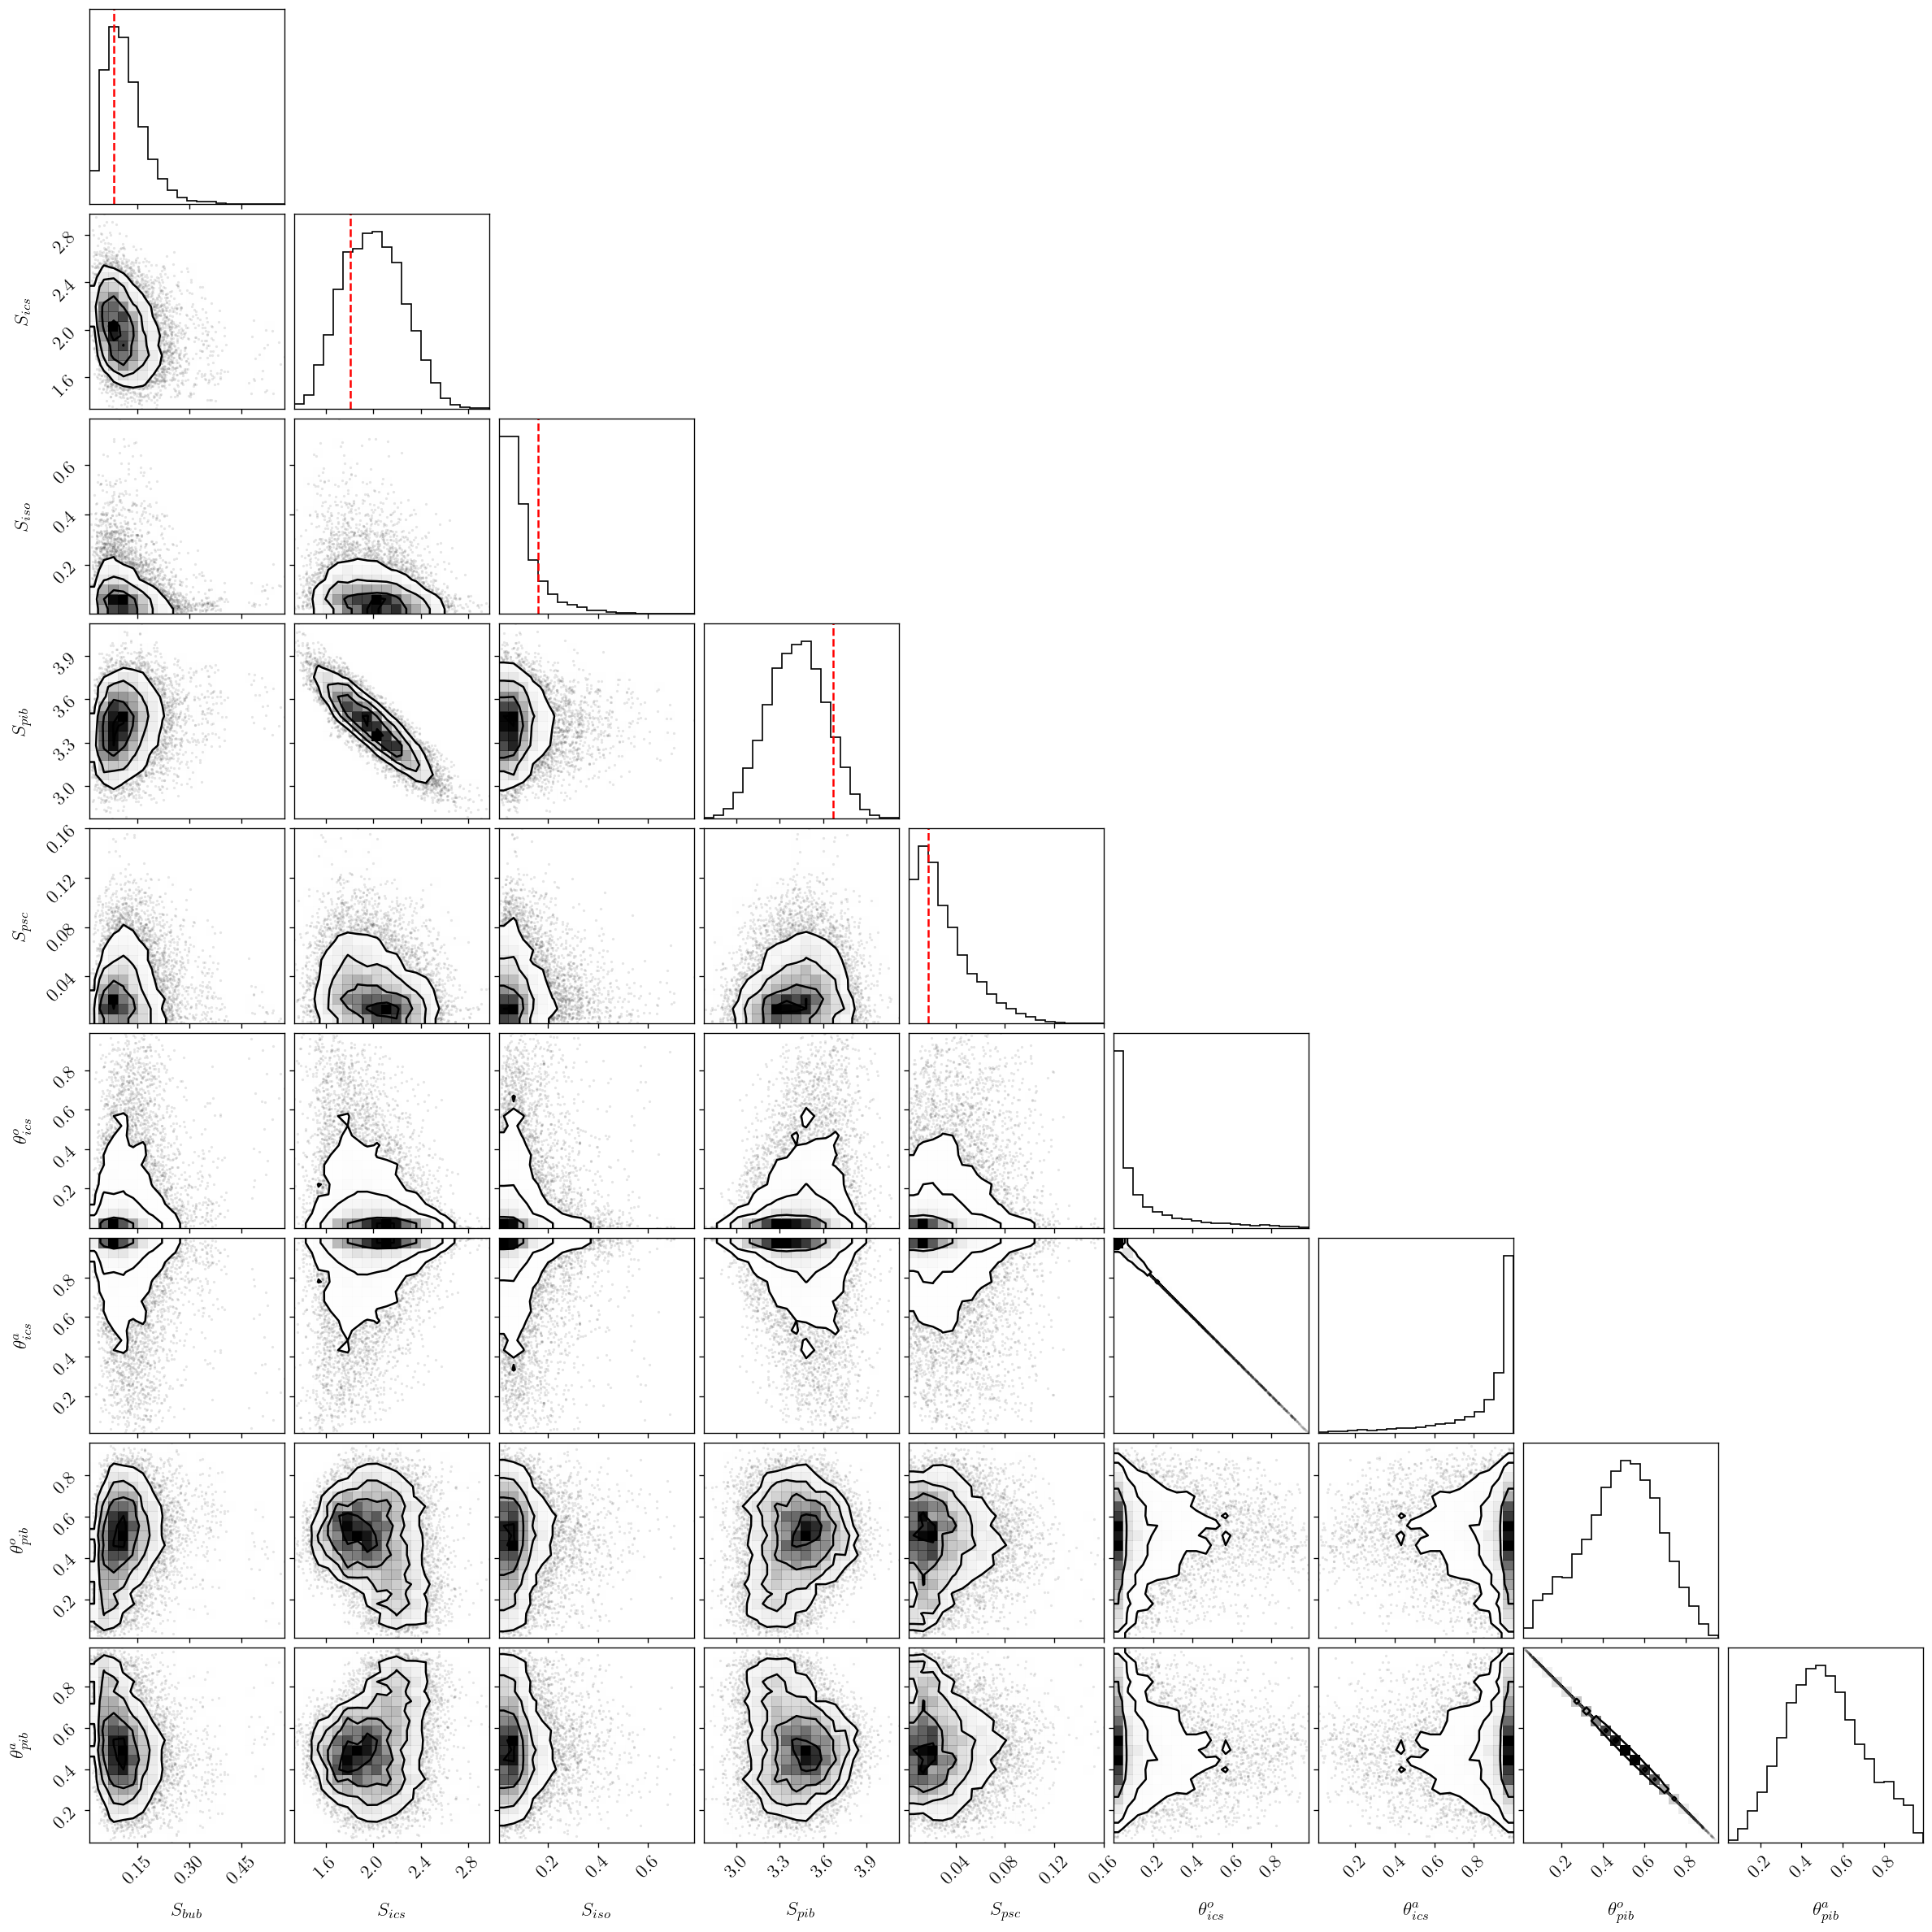

In [11]:
import corner

p_tr = [true_params[k] for k in keys if k not in ['theta_ics', 'theta_pib']]
Np = len(p_tr) 
Ntot = temp_samples_tot_list.T.shape[1]

def gen_labels(keys):
    def format_S(k):
        if 'S' in k:
            return '$S_{'+k.split('_')[1]+'}$'
        return '$'+k+'$'
    def format_theta(k, subscript):
        return '$\\theta_{'+k.split('_')[1]+'}'+'^{'+subscript+'}$'
    
    labels = []
    for k in keys:
        if 'theta' in k:
            for i in range(len(ebinmodel.dif_names)):
                print(k)
                labels.append(format_theta(k, ebinmodel.dif_names[i][-1]))
                print(labels)
        else:
            labels.append(format_S(k))
    return labels
print(keys)
labels = gen_labels(keys)
print(labels)
# labels =['$S_{blg}$', '$S_{bub}$', '$S_{ics}$', '$S_{iso}$', '$S_{nfw}$', '$S_{pib}$', '$S_{psc}$', 
#          '$\\theta_{ics}^{o}$', '$\\theta_{ics}^{a}$', '$\\theta_{pib}^{o}$','$\\theta_{pib}^{a}$']
# labels = ['$S_{bub}$', '$S_{ics}$', '$S_{pib}$', '$S_{psc}$', '$S_{blg}$', '$S_{iso}$', '$S_{nfw}$','$\\gamma$']

fig = corner.corner(temp_samples_tot_list.T, labels = labels, )
axes = np.array(fig.axes).reshape((Ntot, Ntot))
for i in range(Np):
    ax = axes[i,i]
    ax.axvline(p_tr[i], color='red', linestyle='--')

/data/edr76/gce-prob-prog-ed-v0.3/diffuse_model_tests/../utils/ed_fcts_amarel.py:663: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))


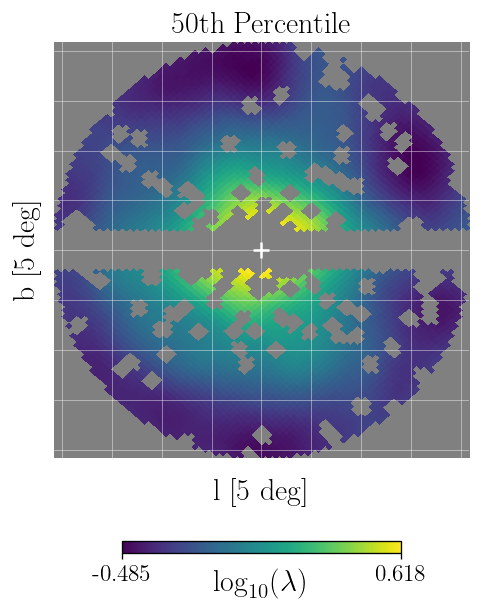

In [12]:
mask = ebinmodel.mask_roi_arr[10]
if is_gp:
    nside = ebinmodel.nside

    q = np.percentile(gp_samples, [16,50,84], axis = 0)

    fig = plt.figure(figsize=(6, 6), dpi= 120)

    map_p = ef.convert_masked_array_to_hp_array(np.exp(q[1]), mask, log_option = True, nside = 128)

    ax = fig.add_subplot(1,1,1)
    plt.axes(ax)
    ef.gnomview_plot(map_p,'50th Percentile')
else:
    print('No GP Model, No GP Samples')

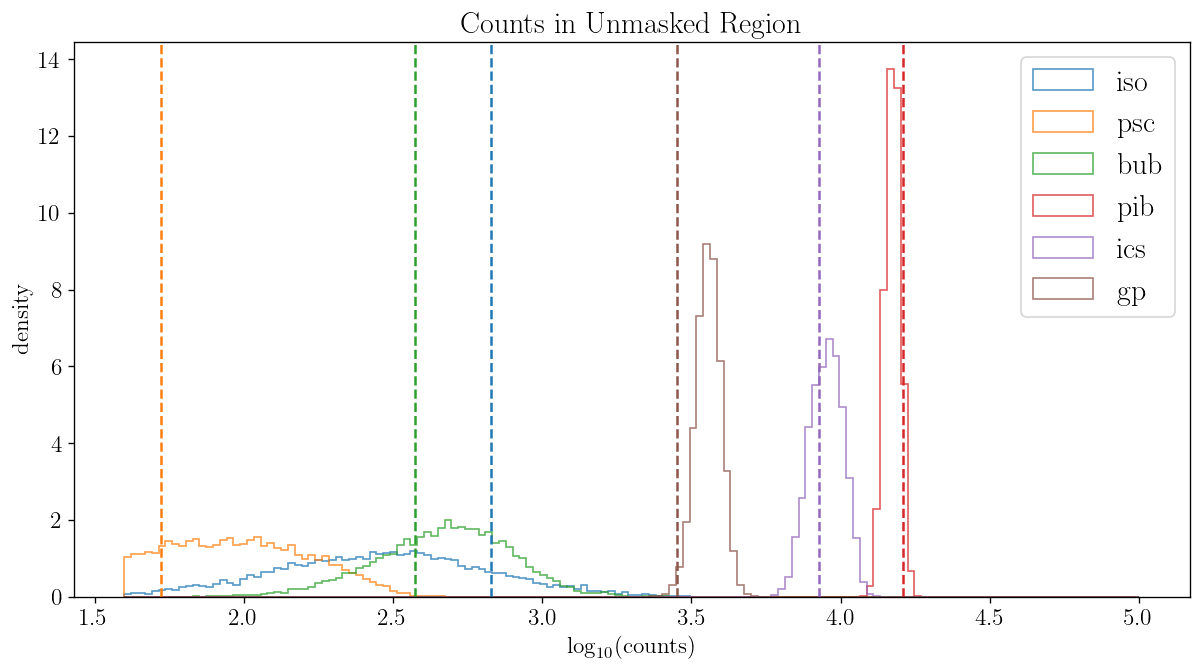

In [13]:
# generate samples and plot histograms of log counts

temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, bins = np.linspace(1.6,5.,150), gp_model_nfw=True, gp_model_iso = False)

In [14]:
# 1D slice of GP posterior
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords()

exp_gp_samples = np.exp(gp_samples)
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels=80, nside = 128)
q = np.percentile(exp_gp_samples_cart, [16,50,84], axis = 0)

gp_temp_list = [temp for temp in ebinmodel.temp_names_sim if temp not in ebinmodel.temp_list]
gp_true = np.array([temp_dict[temp] for temp in gp_temp_list]).sum(axis = 0)
sim_cart = ef.healpix_to_cart(gp_true, mask, n_pixels=80, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

100%|██████████| 10000/10000 [01:16<00:00, 130.16it/s]


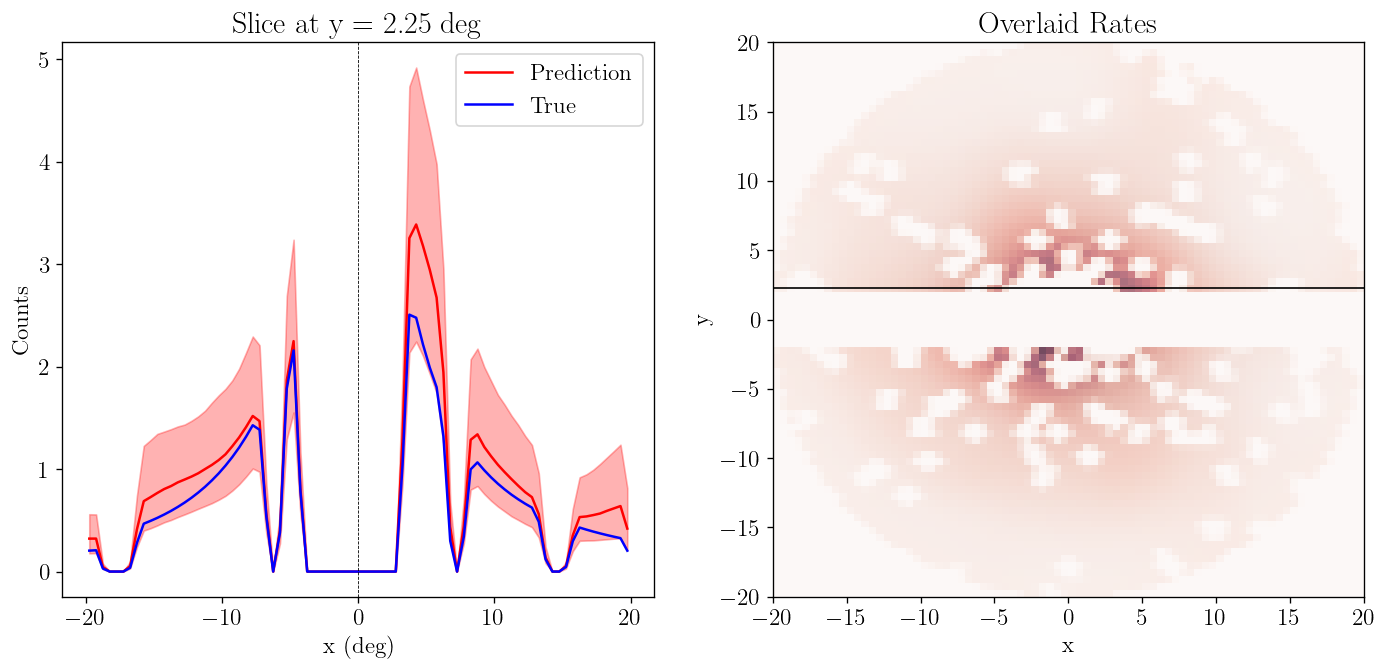

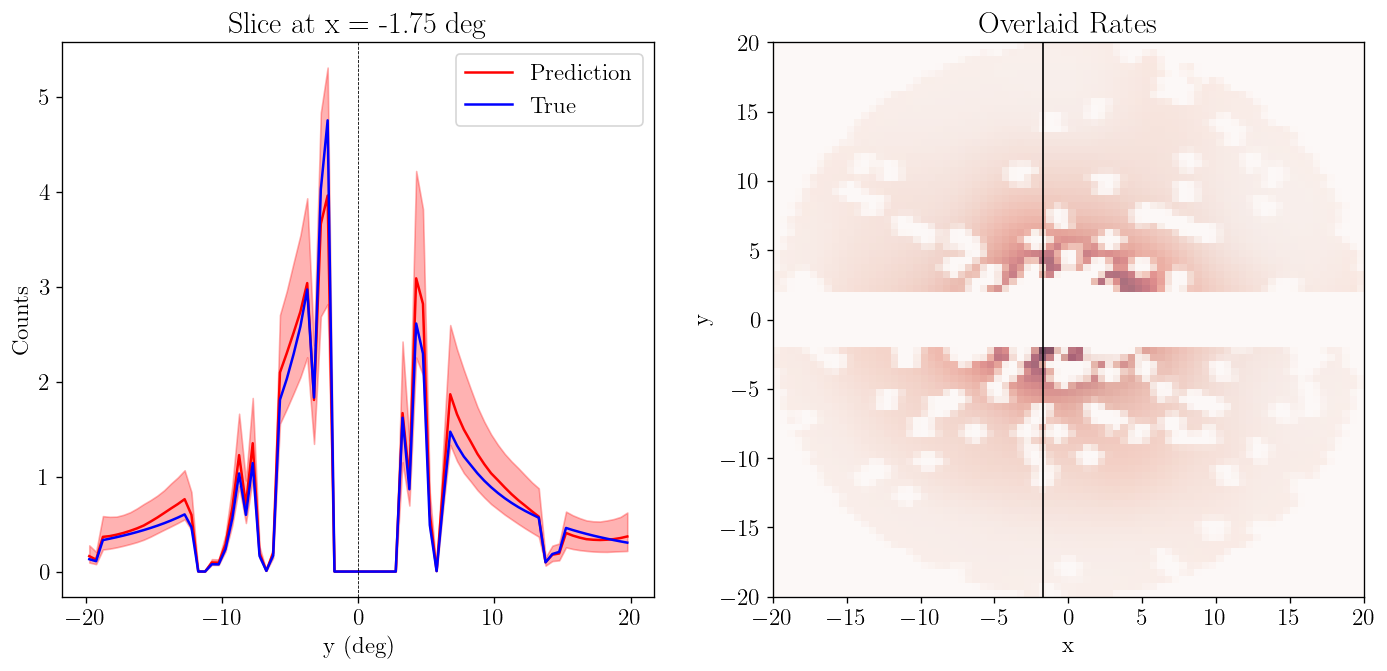

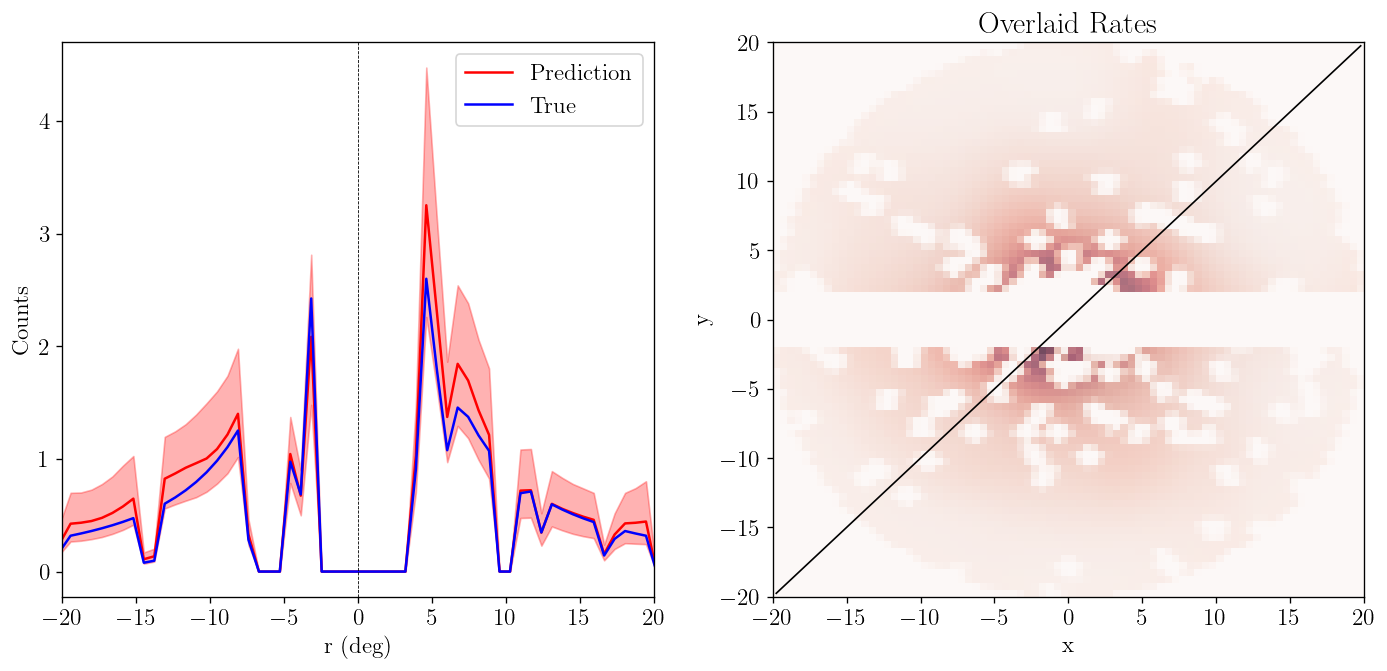

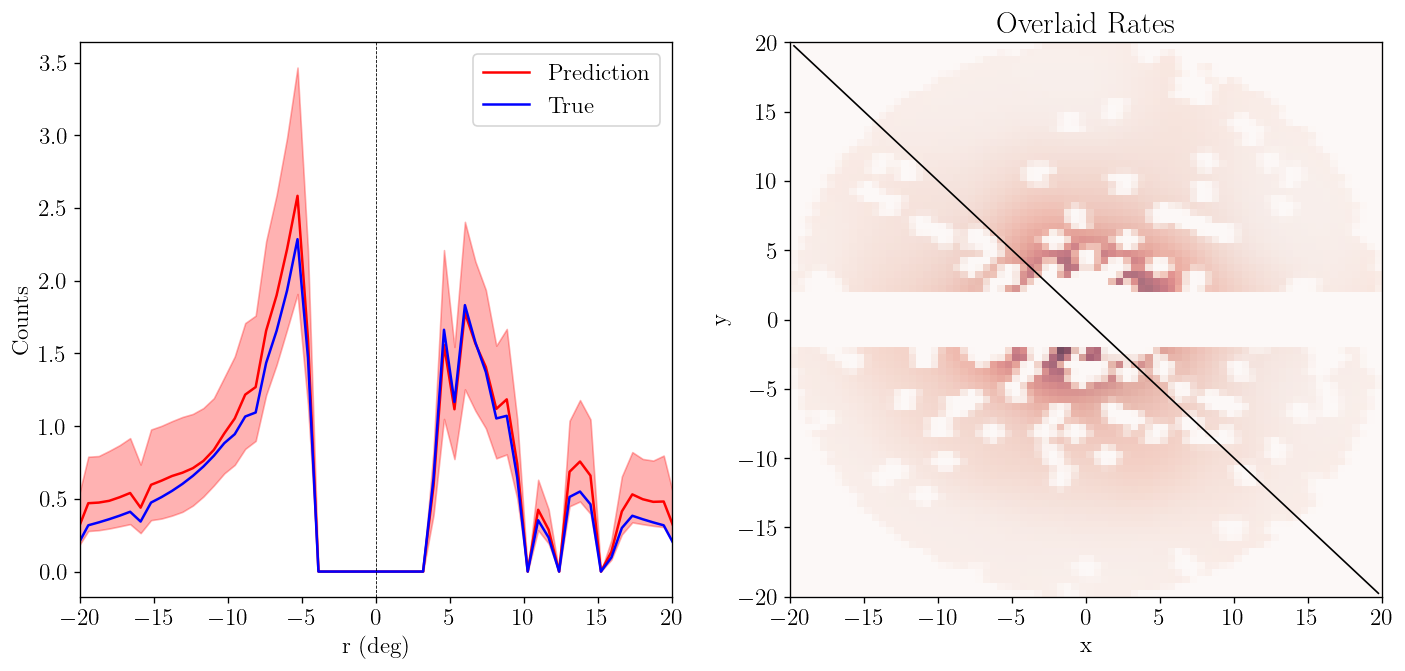

In [15]:
# 1D slice of GP posterior
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'horizontal', slice_val = 2., res_scale = 1, yscale = 'linear')
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'vertical', slice_val = -2., res_scale = 1, yscale = 'linear')
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_up', slice_val = 10., res_scale = 1, yscale = 'linear')
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_down', slice_val = 10., res_scale = 1, yscale = 'linear')

In [16]:
# 1D slice of full posterior
tot_samples = jnp.zeros(temp_sample_dict['gp'].shape)
tot_names = list(temp_sample_dict.keys())
for tot_name in tot_names:
    tot_samples += temp_sample_dict[tot_name]

tot_samples_cart = ef.multi_healpix_to_cart(tot_samples, mask, n_pixels=80, nside = 128)
q_tot = np.percentile(tot_samples_cart, [16,50,84], axis = 0)

sim_samples = jnp.zeros(temp_dict['blg'].shape)
for sim_name in temp_names_sim:
    sim_samples += temp_dict[sim_name]
sim_cart = ef.healpix_to_cart(sim_samples, mask, n_pixels=80, nside = 128)

raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

100%|██████████| 10000/10000 [02:30<00:00, 66.51it/s]


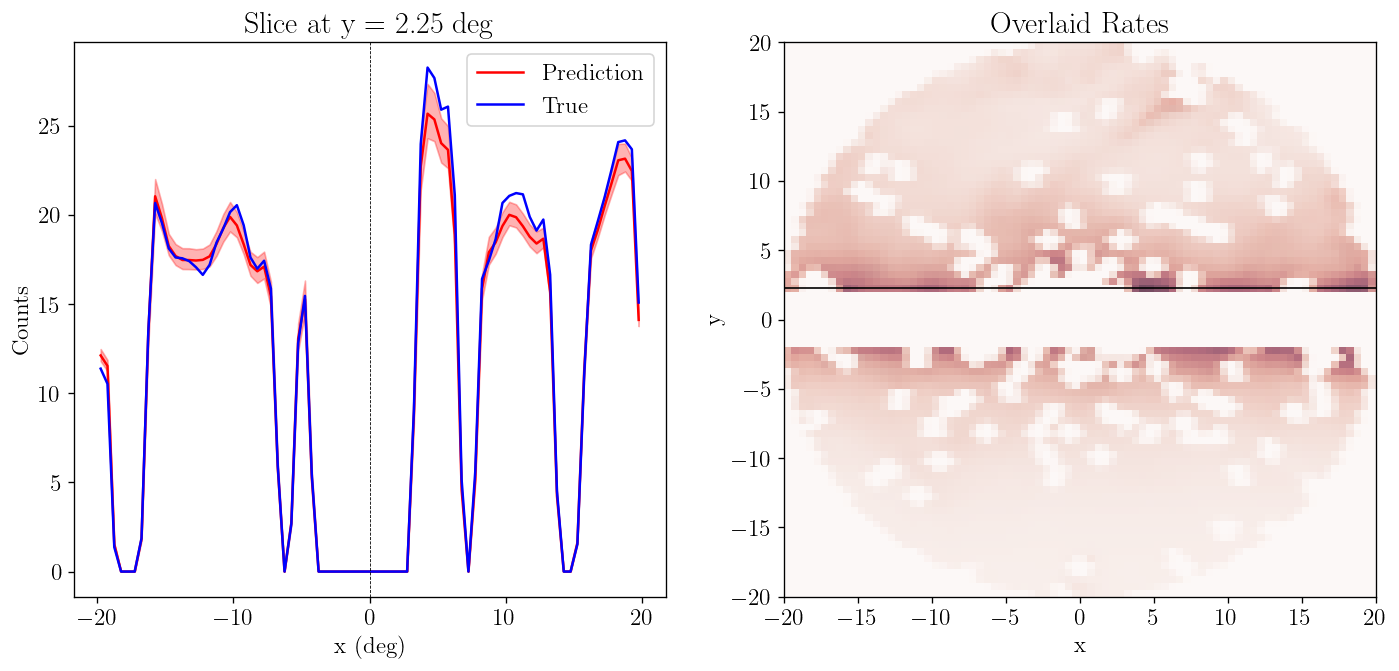

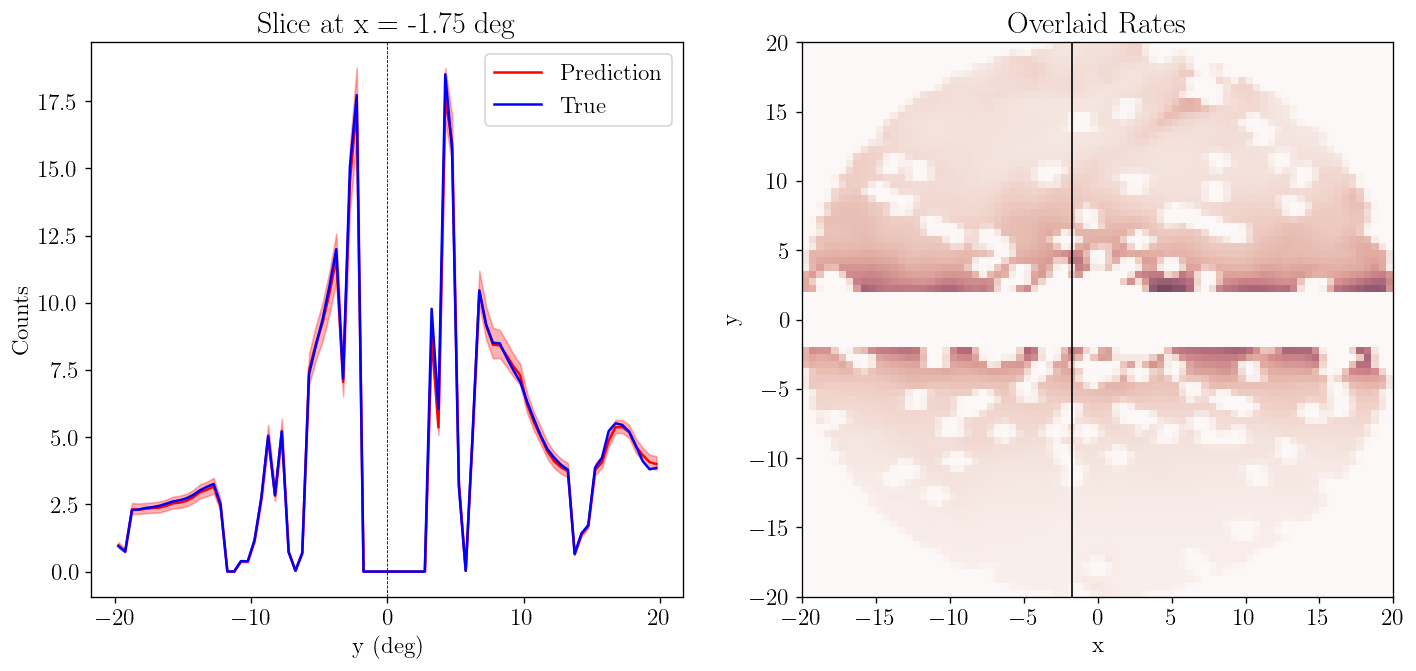

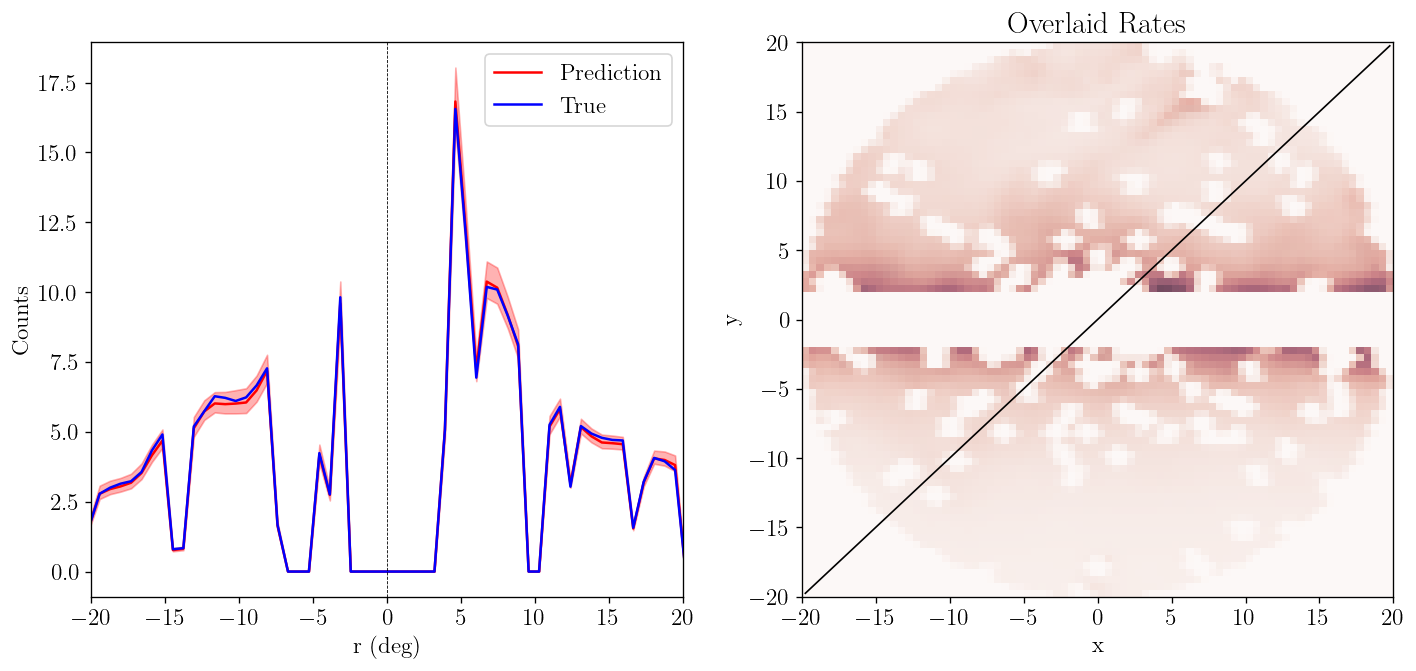

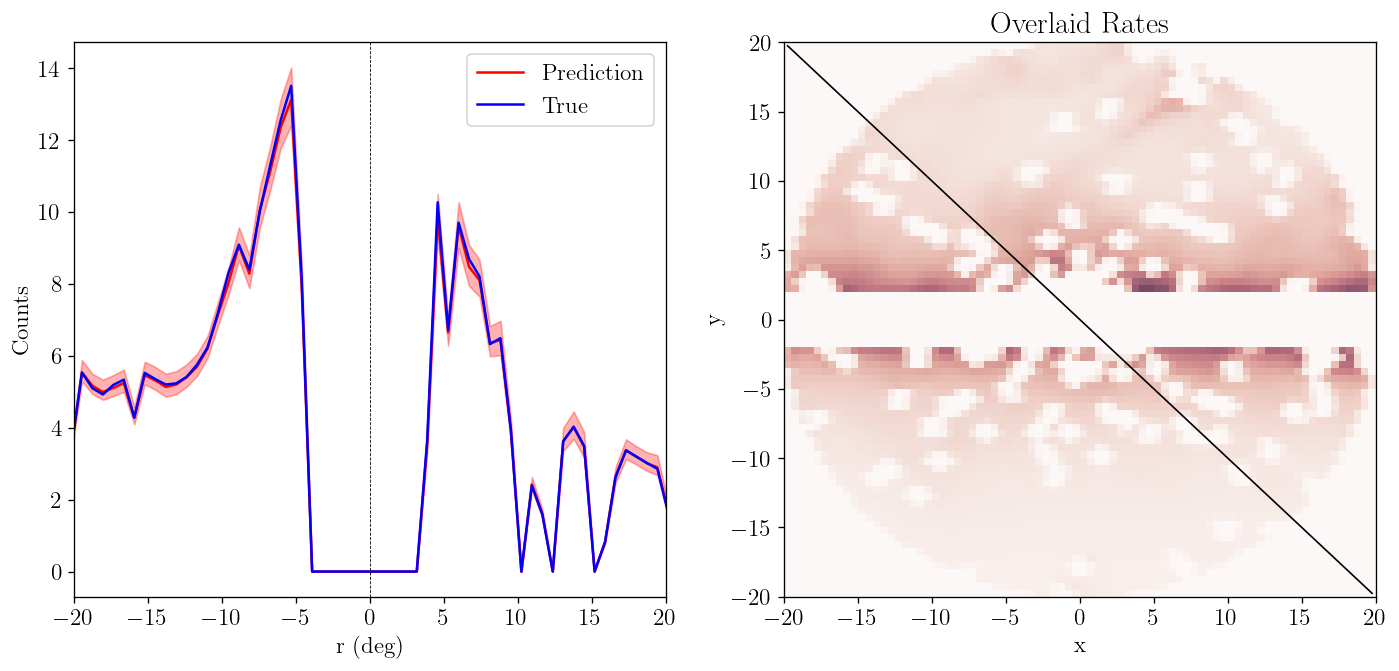

In [17]:
# 1D slice of full posterior
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, None, slice_dir = 'horizontal', slice_val = 2., res_scale = 1, yscale = 'linear')
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, None, slice_dir = 'vertical', slice_val = -2., res_scale = 1, yscale = 'linear')
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, None, slice_dir = 'diagonal_up', slice_val = 2., res_scale = 1, yscale = 'linear')
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, None, slice_dir = 'diagonal_down', slice_val = 2., res_scale = 1, yscale = 'linear')

In [18]:
# ie = 10
# mask_p = ebinmodel.mask_roi_arr[ie]
# num_samples = 1000
# name = 'pib'
# temp_sample_dict = {}

# S_pib = samples['S_' + name]
# pib_temps_at_bin = jnp.asarray([pib_temp.at_bin(ie, mask=mask_p) for pib_temp in ebinmodel.pib_temps])
# theta = samples['theta_' + name]
# pib_temp = np.dot(theta, pib_temps_at_bin)

In [19]:
# print( ( S_pib[0] * pib_temp[0,:] ).shape)

In [20]:
# ie = 10
# mask_p = ebinmodel.mask_roi_arr[ie]
# num_samples = 1000
# name = 'pib'
# temp_sample_dict = {}
# if name == 'pib':
#     S_pib = samples['S_' + name]
#     pib_temps_at_bin = jnp.asarray([pib_temp.at_bin(ie, mask=mask_p) for pib_temp in ebinmodel.pib_temps])
#     if ebinmodel.n_dif_temps == 1:
#         temp_sample_dict[name] = np.array([S_pib[i] * pib_temps_at_bin[0] for i in tqdm(range(num_samples))])
#     else:
#         theta = samples['theta_' + name]
#         pib_temp = np.dot(theta, pib_temps_at_bin)
#         temp_sample_dict[name] = np.array([S_pib[i] * pib_temp[i,:] for i in tqdm(range(num_samples))])